In [38]:
import os
os.environ["MKL_THREADING_LAYER"] = "TBB"

import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier
import joblib
import matplotlib.pyplot as plt
import time

In [39]:
features_to_use = ['lbp', 'hog', 'color', 'gabor'] #Added all features for baseline.
use_pca = True #This way we can enable/disable PCA.
pca_variance_threshold = 0.95 #Keep components explaining 95% of variance.

models = {
    'Random Forest': RandomForestClassifier(random_state=1),
    'Gradient Boosting': GradientBoostingClassifier(random_state=1),
    'SVM': SVC(random_state=1, probability=True),  #Added probability=True for better predictions.
    'KNN': KNeighborsClassifier(n_neighbors=1)
}

In [40]:
#These functions help set a loop/pipeline for experimenting with different features/models.
def load_and_combine_features(real_path, fake_path, features_to_use):
    """Load features but keep them separate (don't concatenate yet)"""
    real_data = np.load(real_path)
    fake_data = np.load(fake_path)

    print(f"  Feature dimensions in {real_path}:")
    for feature in features_to_use:
        print(f"    {feature}: {real_data[feature].shape[1]} features")
    
    #Store features separately as a dictionary.
    feature_dict = {}
    for feature in features_to_use:
        real_feat = real_data[feature]
        fake_feat = fake_data[feature]
        #Combine real and fake for this feature type.
        feature_dict[feature] = np.vstack([fake_feat, real_feat])
    
    #Create labels.
    y = np.hstack([np.zeros(len(fake_data[features_to_use[0]])),np.ones(len(real_data[features_to_use[0]]))])
    
    return feature_dict, y

def print_metrics(y_true, y_pred, y_pred_proba, dataset_name, model_name, inference_time=None):
    #We choose the following evaluation metrics.
    Acc = accuracy_score(y_true, y_pred)
    F1 = f1_score(y_true, y_pred)
    Precision = precision_score(y_true, y_pred)
    Recall = recall_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    
    #Calculate ROC-AUC.
    if y_pred_proba is not None:
        roc_auc = roc_auc_score(y_true, y_pred_proba)
    else:
        roc_auc = None
    
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    
    #Extract confusion matrix values.
    tn, fp, fn, tp = cm.ravel()

    print(f"\n{model_name} - {dataset_name} Results:")
    if inference_time is not None:
        print(f" Inference Time: {inference_time:.4f} seconds")
    print(f" Accuracy: {Acc:.4f}")
    print(f" Precision: {Precision:.4f}")
    print(f" Recall: {Recall:.4f}")
    print(f" F1 Score: {F1:.4f}")
    if roc_auc is not None:
        print(f" ROC-AUC: {roc_auc:.4f}")
    print(f" Confusion Matrix:")
    print(f"   {cm}")

    print(f"\n CONFUSION MATRIX BREAKDOWN:")
    print(f"  True Negatives  (TN): {tn:4d} - Correctly identified as Fake")
    print(f"  False Positives (FP): {fp:4d} - Fake wrongly identified as Real")
    print(f"  False Negatives (FN): {fn:4d} - Real wrongly identified as Fake")
    print(f"  True Positives  (TP): {tp:4d} - Correctly identified as Real")
    
    #Detailed Error analysis.
    total_errors = fp + fn
    total_samples = len(y_true)
    print(f"\n ERROR ANALYSIS:")
    print(f"  Total Errors: {total_errors}/{total_samples} ({total_errors/total_samples*100:.2f}%)")
    print(f"  False Positives: {fp} ({fp/total_samples*100:.2f}%) - Fake images classified as Real")
    print(f"  False Negatives: {fn} ({fn/total_samples*100:.2f}%) - Real images classified as Fake")
    
    return roc_auc

In [41]:
print("\n--- Train ---")
X_train_dict, y_train = load_and_combine_features(
    'train_real_all_features.npz',
    'train_fake_all_features.npz',
    features_to_use
)
print("\n--- Validation ---")
X_valid_dict, y_valid = load_and_combine_features(
    'valid_real_all_features.npz',
    'valid_fake_all_features.npz',
    features_to_use
)
print("\n--- Test ---")
X_test_dict, y_test = load_and_combine_features(
    'test_real_all_features.npz',
    'test_fake_all_features.npz',
    features_to_use
)

#Calculate total features.
total_features = sum(X_train_dict[feat].shape[1] for feat in features_to_use)
num_samples_train = X_train_dict[features_to_use[0]].shape[0]
num_samples_valid = X_valid_dict[features_to_use[0]].shape[0]
num_samples_test = X_test_dict[features_to_use[0]].shape[0]

print(f"\nTrain set: ({num_samples_train}, {total_features})")
print(f"Valid set: ({num_samples_valid}, {total_features})")
print(f"Test set: ({num_samples_test}, {total_features})")
print(f"Total features used: {total_features}")

print("\n--- Class Balance ---")
print(f"Train - Real: {np.sum(y_train == 0)}, Fake: {np.sum(y_train == 1)}")
print(f"Valid - Real: {np.sum(y_valid == 0)}, Fake: {np.sum(y_valid == 1)}")
print(f"Test  - Real: {np.sum(y_test == 0)}, Fake: {np.sum(y_test == 1)}")


--- Train ---
  Feature dimensions in train_real_all_features.npz:
    lbp: 59 features
    hog: 1764 features
    color: 6 features
    gabor: 8 features

--- Validation ---
  Feature dimensions in valid_real_all_features.npz:
    lbp: 59 features
    hog: 1764 features
    color: 6 features
    gabor: 8 features

--- Test ---
  Feature dimensions in test_real_all_features.npz:
    lbp: 59 features
    hog: 1764 features
    color: 6 features
    gabor: 8 features

Train set: (10000, 1837)
Valid set: (2000, 1837)
Test set: (2000, 1837)
Total features used: 1837

--- Class Balance ---
Train - Real: 5000, Fake: 5000
Valid - Real: 1000, Fake: 1000
Test  - Real: 1000, Fake: 1000


In [42]:
#Scaling all features individually (before PCA).
print("\nScaling features individually")

#Dictionary to store scalers for each feature type.
scalers = {}
X_train_scaled_dict = {}
X_valid_scaled_dict = {}
X_test_scaled_dict = {}

#Scale each feature type separately.
for feature in features_to_use:
    print(f"  Scaling {feature}")
    scaler = StandardScaler()
    
    #Fit on train, transform all sets.
    X_train_scaled_dict[feature] = scaler.fit_transform(X_train_dict[feature])
    X_valid_scaled_dict[feature] = scaler.transform(X_valid_dict[feature])
    X_test_scaled_dict[feature] = scaler.transform(X_test_dict[feature])
    
    #Store scaler for this feature.
    scalers[feature] = scaler

#Now concatenate all scaled features.
X_train_scaled = np.concatenate([X_train_scaled_dict[f] for f in features_to_use], axis=1)
X_valid_scaled = np.concatenate([X_valid_scaled_dict[f] for f in features_to_use], axis=1)
X_test_scaled = np.concatenate([X_test_scaled_dict[f] for f in features_to_use], axis=1)

print(f"\nFinal concatenated shape: {X_train_scaled.shape}")

#Save scalers.
joblib.dump(scalers, 'scalers_dict.joblib')
print("Scalers saved to 'scalers_dict.joblib'")


Scaling features individually
  Scaling lbp
  Scaling hog
  Scaling color
  Scaling gabor

Final concatenated shape: (10000, 1837)
Scalers saved to 'scalers_dict.joblib'


In [43]:
from sklearn.decomposition import PCA
#Apply PCA.
if use_pca:
    #We fit PCA on training data only.
    pca = PCA(n_components=pca_variance_threshold, random_state=1)
    X_train_pca = pca.fit_transform(X_train_scaled)

    #We transform validation and test using the fitted PCA.
    X_valid_pca = pca.transform(X_valid_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    n_components = pca.n_components_
    explained_var = np.sum(pca.explained_variance_ratio_)
    print(f"\nPCA Results:")
    print(f" Original features: {X_train_scaled.shape[1]}")
    print(f" Components retained: {n_components}")
    print(f" Explained variance: {explained_var:.4f} ({explained_var*100:.2f}%)")
    print(f" Dimensionality reduction: {X_train_scaled.shape[1]} --> {n_components}")

    joblib.dump(pca, 'pca.joblib')
    print("PCA saved to 'pca.joblib'")

    #Use PCA-transformed data for training.
    X_train_final = X_train_pca
    X_valid_final = X_valid_pca
    X_test_final = X_test_pca

else:
    print("\nPCA Disabled")
    X_train_final = X_train_scaled
    X_valid_final = X_valid_scaled
    X_test_final = X_test_scaled


PCA Results:
 Original features: 1837
 Components retained: 480
 Explained variance: 0.9501 (95.01%)
 Dimensionality reduction: 1837 --> 480
PCA saved to 'pca.joblib'


## Baseline Training - All Models

In [44]:
import time 

#Time to train and evaluate all models on validation set.
trained_models = {}
roc_data = {} #Store ROC curve data for plotting.
validation_results = {}  #Store validation metrics for comparison.

for model_name, model in models.items():
    print(f"\n{'+'*25}")
    print(f"Training {model_name}")

    #Start timing for training.
    start_time = time.time()
    
    #Training.
    model.fit(X_train_final, y_train)
    
    #End timing for training.
    training_time = time.time() - start_time
    print(f"\nTraining completed in {training_time:.2f} seconds")

    #Predicting on train set (for overfitting check).
    y_train_pred = model.predict(X_train_final)
    
    #Predicting on validation set (along with inference time tracking).
    inference_start = time.time()
    y_valid_pred = model.predict(X_valid_final)
    inference_time = time.time() - inference_start
    
    # Check if model supports predict_proba to get probability predictions for ROC-AUC.
    if hasattr(model, "predict_proba"):
        y_train_proba = model.predict_proba(X_train_final)[:, 1]
        y_valid_proba = model.predict_proba(X_valid_final)[:, 1]
    elif hasattr(model, "decision_function"):  #For SVM.
        y_train_proba = model.decision_function(X_train_final)
        y_valid_proba = model.decision_function(X_valid_final)
    else:
        y_train_proba = None
        y_valid_proba = None

    #Printing metrics for train and validation.
    print_metrics(y_train, y_train_pred, y_train_proba, "Train", model_name)
    valid_auc = print_metrics(y_valid, y_valid_pred, y_valid_proba, "Validation", model_name, inference_time)
    
    #Store validation results for comparison.
    validation_results[model_name] = {
        'accuracy': accuracy_score(y_valid, y_valid_pred),
        'f1_score': f1_score(y_valid, y_valid_pred),
        'roc_auc': valid_auc,
        'training_time': training_time,
        'inference_time': inference_time
    }
    
    #Store ROC curve data for validation set.
    if y_valid_proba is not None:
        fpr, tpr, _ = roc_curve(y_valid, y_valid_proba)
        roc_data[model_name] = {
            'fpr': fpr, 
            'tpr': tpr, 
            'auc': valid_auc,
            'training_time': training_time,
            'inference_time': inference_time
        }

    #Saving models.
    model_filename = f"{model_name.lower().replace(' ', '_')}_model.joblib"
    joblib.dump(model, model_filename)
    print(f"\nModel saved to '{model_filename}'")

    #Storing in dictionary.
    trained_models[model_name] = model

print("\n" + "="*25)
print("VALIDATION PHASE COMPLETE")
print("="*25)
print("\nValidation Results Summary:")
print(f"{'Model':<20} {'Accuracy':<10} {'F1-Score':<10} {'ROC-AUC':<10} {'Train(s)':<10} {'Infer(s)':<10}")
print("-"*35)
for model_name, results in validation_results.items():
    print(f"{model_name:<20} {results['accuracy']:<10.4f} {results['f1_score']:<10.4f} "
          f"{results['roc_auc']:<10.4f} {results['training_time']:<10.2f} {results['inference_time']:<10.4f}")

print("\n" + "="*25)



+++++++++++++++++++++++++
Training Random Forest

Training completed in 59.66 seconds

Random Forest - Train Results:
 Accuracy: 1.0000
 Precision: 1.0000
 Recall: 1.0000
 F1 Score: 1.0000
 ROC-AUC: 1.0000
 Confusion Matrix:
   [[5000    0]
 [   0 5000]]

 CONFUSION MATRIX BREAKDOWN:
  True Negatives  (TN): 5000 - Correctly identified as Fake
  False Positives (FP):    0 - Fake wrongly identified as Real
  False Negatives (FN):    0 - Real wrongly identified as Fake
  True Positives  (TP): 5000 - Correctly identified as Real

 ERROR ANALYSIS:
  Total Errors: 0/10000 (0.00%)
  False Positives: 0 (0.00%) - Fake images classified as Real
  False Negatives: 0 (0.00%) - Real images classified as Fake

Random Forest - Validation Results:
 Inference Time: 0.1104 seconds
 Accuracy: 0.7180
 Precision: 0.7220
 Recall: 0.7090
 F1 Score: 0.7154
 ROC-AUC: 0.7888
 Confusion Matrix:
   [[727 273]
 [291 709]]

 CONFUSION MATRIX BREAKDOWN:
  True Negatives  (TN):  727 - Correctly identified as Fake
  

## PCA Variance Threshold Experimentation

In [45]:
test_model = 'SVM'
variance_thresholds = [0.80, 0.85, 0.90, 0.95, 0.99]

print(f"\n{'='*20}")
print(f"PCA VARIANCE THRESHOLD EXPERIMENTATION")
print(f"Testing model: {test_model}")
print(f"{'='*20}\n")

pca_results = []

for threshold in variance_thresholds:
    print(f"\n{'*'*25}")
    print(f"Testing PCA variance threshold: {threshold} ({threshold*100:.0f}%)")
    print(f"{'*'*25}")
    
    #Apply PCA with current threshold.
    pca_temp = PCA(n_components=threshold, random_state=1)
    X_train_pca_temp = pca_temp.fit_transform(X_train_scaled)
    X_valid_pca_temp = pca_temp.transform(X_valid_scaled)
    
    n_components = pca_temp.n_components_
    explained_var = np.sum(pca_temp.explained_variance_ratio_)
    
    print(f"\nPCA Info:")
    print(f"  Components retained: {n_components}")
    print(f"  Explained variance: {explained_var:.4f} ({explained_var*100:.2f}%)")
    print(f"  Dimensionality: {X_train_scaled.shape[1]} --> {n_components}")
    print(f"  Reduction: {(1 - n_components/X_train_scaled.shape[1])*100:.1f}%")
    
    #Train model with this PCA configuration.
    model_temp = models[test_model].__class__(**models[test_model].get_params())
    
    #Training.
    train_start = time.time()
    model_temp.fit(X_train_pca_temp, y_train)
    train_time = time.time() - train_start
    
    # Validation prediction with inference time
    infer_start = time.time()
    y_valid_pred_temp = model_temp.predict(X_valid_pca_temp)
    infer_time = time.time() - infer_start
    
    #Get probabilities.
    if hasattr(model_temp, "predict_proba"):
        y_valid_proba_temp = model_temp.predict_proba(X_valid_pca_temp)[:, 1]
    elif hasattr(model_temp, "decision_function"):
        y_valid_proba_temp = model_temp.decision_function(X_valid_pca_temp)
    else:
        y_valid_proba_temp = None
    
    #Calculate metrics.
    acc = accuracy_score(y_valid, y_valid_pred_temp)
    f1 = f1_score(y_valid, y_valid_pred_temp)
    precision = precision_score(y_valid, y_valid_pred_temp)
    recall = recall_score(y_valid, y_valid_pred_temp)
    
    if y_valid_proba_temp is not None:
        roc_auc = roc_auc_score(y_valid, y_valid_proba_temp)
    else:
        roc_auc = None
    
    print(f"\nValidation Performance:")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    if roc_auc:
        print(f"  ROC-AUC:   {roc_auc:.4f}")
    print(f"  Training time:   {train_time:.4f}s")
    print(f"  Inference time:  {infer_time:.4f}s")
    
    #Store results.
    pca_results.append({
        'threshold': threshold,
        'n_components': n_components,
        'explained_variance': explained_var,
        'accuracy': acc,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'roc_auc': roc_auc,
        'train_time': train_time,
        'inference_time': infer_time
    })

#Summary table.
print(f"\n{'='*25}")
print(f"PCA VARIANCE THRESHOLD COMPARISON - {test_model}")
print(f"{'='*25}")
print(f"{'Threshold':<12} {'Components':<12} {'Accuracy':<10} {'F1-Score':<10} {'ROC-AUC':<10} {'Train(s)':<10} {'Infer(s)':<10}")
print("-"*25)

for result in pca_results:
    print(f"{result['threshold']:<12.2f} {result['n_components']:<12d} {result['accuracy']:<10.4f} "
          f"{result['f1_score']:<10.4f} {result['roc_auc']:<10.4f} "
          f"{result['train_time']:<10.4f} {result['inference_time']:<10.4f}")

#Find best threshold.
best_by_accuracy = max(pca_results, key=lambda x: x['accuracy'])
best_by_f1 = max(pca_results, key=lambda x: x['f1_score'])
best_by_auc = max(pca_results, key=lambda x: x['roc_auc']) if pca_results[0]['roc_auc'] else None

print(f"\n{'='*25}")
print("OPTIMAL THRESHOLDS:")
print(f"  Best Accuracy:  {best_by_accuracy['threshold']:.2f} (Acc: {best_by_accuracy['accuracy']:.4f}, Components: {best_by_accuracy['n_components']})")
print(f"  Best F1-Score:  {best_by_f1['threshold']:.2f} (F1: {best_by_f1['f1_score']:.4f}, Components: {best_by_f1['n_components']})")
if best_by_auc:
    print(f"  Best ROC-AUC:   {best_by_auc['threshold']:.2f} (AUC: {best_by_auc['roc_auc']:.4f}, Components: {best_by_auc['n_components']})")
print(f"{'='*25}")


PCA VARIANCE THRESHOLD EXPERIMENTATION
Testing model: SVM


*************************
Testing PCA variance threshold: 0.8 (80%)
*************************

PCA Info:
  Components retained: 207
  Explained variance: 0.8005 (80.05%)
  Dimensionality: 1837 --> 207
  Reduction: 88.7%

Validation Performance:
  Accuracy:  0.8235
  Precision: 0.8373
  Recall:    0.8030
  F1-Score:  0.8198
  ROC-AUC:   0.8992
  Training time:   143.3790s
  Inference time:  7.3384s

*************************
Testing PCA variance threshold: 0.85 (85%)
*************************

PCA Info:
  Components retained: 267
  Explained variance: 0.8504 (85.04%)
  Dimensionality: 1837 --> 267
  Reduction: 85.5%

Validation Performance:
  Accuracy:  0.8230
  Precision: 0.8393
  Recall:    0.7990
  F1-Score:  0.8186
  ROC-AUC:   0.9002
  Training time:   149.3183s
  Inference time:  8.1871s

*************************
Testing PCA variance threshold: 0.9 (90%)
*************************

PCA Info:
  Components retained: 349
  

## Individual Model Fine-Tuning

In [46]:
model_to_finetune = 'SVM'

if model_to_finetune == 'SVM':
    fine_tuned_model = SVC(
        C=10,
        kernel='rbf',
        gamma='scale',
        probability=True,
        random_state=1
    )

elif model_to_finetune == 'Random Forest':
    fine_tuned_model = RandomForestClassifier(
        n_estimators=350,
        max_depth=50,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features='sqrt',
        random_state=1
    )

elif model_to_finetune == 'Gradient Boosting':
    fine_tuned_model = GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.2,
        max_depth=5,
        min_samples_split=2,
        min_samples_leaf=1,
        subsample=1.0,
        random_state=1
    )

elif model_to_finetune == 'KNN':
    fine_tuned_model = KNeighborsClassifier(
        n_neighbors=1,
        weights='uniform',
        algorithm='auto',
        metric='minkowski',
        p=2
    )

print(f"\n{'='*20}")
print(f"FINE-TUNING: {model_to_finetune}")
print(f"{'='*20}")
print(f"\nModel Configuration:")
print(fine_tuned_model.get_params())

#Training.
print(f"\n{'*'*40}")
print("Training fine-tuned model...")
train_start = time.time()
fine_tuned_model.fit(X_train_final, y_train)
train_time = time.time() - train_start
print(f"Training completed in {train_time:.2f} seconds")

#Predictions on train set.
y_train_pred_ft = fine_tuned_model.predict(X_train_final)

#Predictions on validation set with inference time.
infer_start = time.time()
y_valid_pred_ft = fine_tuned_model.predict(X_valid_final)
infer_time = time.time() - infer_start

#Get probabilities.
if hasattr(fine_tuned_model, "predict_proba"):
    y_train_proba_ft = fine_tuned_model.predict_proba(X_train_final)[:, 1]
    y_valid_proba_ft = fine_tuned_model.predict_proba(X_valid_final)[:, 1]
elif hasattr(fine_tuned_model, "decision_function"):
    y_train_proba_ft = fine_tuned_model.decision_function(X_train_final)
    y_valid_proba_ft = fine_tuned_model.decision_function(X_valid_final)
else:
    y_train_proba_ft = None
    y_valid_proba_ft = None

#Print metrics.
print_metrics(y_train, y_train_pred_ft, y_train_proba_ft, "Train", f"Fine-tuned {model_to_finetune}")
print_metrics(y_valid, y_valid_pred_ft, y_valid_proba_ft, "Validation", f"Fine-tuned {model_to_finetune}", infer_time)

#Comparison with baseline.
print(f"\n{'='*25}")
print("Comparison Wtih Baseline")
print(f"{'='*25}")

baseline_acc = validation_results[model_to_finetune]['accuracy']
baseline_f1 = validation_results[model_to_finetune]['f1_score']
baseline_auc = validation_results[model_to_finetune]['roc_auc']
baseline_train_time = validation_results[model_to_finetune]['training_time']
baseline_infer_time = validation_results[model_to_finetune]['inference_time']

finetuned_acc = accuracy_score(y_valid, y_valid_pred_ft)
finetuned_f1 = f1_score(y_valid, y_valid_pred_ft)
finetuned_auc = roc_auc_score(y_valid, y_valid_proba_ft) if y_valid_proba_ft is not None else None

print(f"\n{'Metric':<20} {'Baseline':<15} {'Fine-tuned':<15} {'Change':<15}")
print("-"*65)
print(f"{'Accuracy':<20} {baseline_acc:<15.4f} {finetuned_acc:<15.4f} {finetuned_acc - baseline_acc:+.4f}")
print(f"{'F1-Score':<20} {baseline_f1:<15.4f} {finetuned_f1:<15.4f} {finetuned_f1 - baseline_f1:+.4f}")
if finetuned_auc:
    print(f"{'ROC-AUC':<20} {baseline_auc:<15.4f} {finetuned_auc:<15.4f} {finetuned_auc - baseline_auc:+.4f}")
print(f"{'Training Time (s)':<20} {baseline_train_time:<15.2f} {train_time:<15.2f} {train_time - baseline_train_time:+.2f}")
print(f"{'Inference Time (s)':<20} {baseline_infer_time:<15.4f} {infer_time:<15.4f} {infer_time - baseline_infer_time:+.4f}")

#Save fine-tuned model if performance improved.
if finetuned_acc > baseline_acc or finetuned_f1 > baseline_f1:
    model_filename = f"{model_to_finetune.lower().replace(' ', '_')}_finetuned_model.joblib"
    joblib.dump(fine_tuned_model, model_filename)
    print(f"\nFine-tuned model saved to '{model_filename}'")
else:
    print(f"\nNo improvement detected.")

trained_models[model_to_finetune] = fine_tuned_model


FINE-TUNING: SVM

Model Configuration:
{'C': 10, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': 1, 'shrinking': True, 'tol': 0.001, 'verbose': False}

****************************************
Training fine-tuned model...
Training completed in 457.57 seconds

Fine-tuned SVM - Train Results:
 Accuracy: 1.0000
 Precision: 1.0000
 Recall: 1.0000
 F1 Score: 1.0000
 ROC-AUC: 1.0000
 Confusion Matrix:
   [[5000    0]
 [   0 5000]]

 CONFUSION MATRIX BREAKDOWN:
  True Negatives  (TN): 5000 - Correctly identified as Fake
  False Positives (FP):    0 - Fake wrongly identified as Real
  False Negatives (FN):    0 - Real wrongly identified as Fake
  True Positives  (TP): 5000 - Correctly identified as Real

 ERROR ANALYSIS:
  Total Errors: 0/10000 (0.00%)
  False Positives: 0 (0.00%) - Fake images classified as Real
  False Negatives: 

## Final Test Set Evaluation

In [47]:
final_model_choice = 'SVM'

print(f"\n{'#'*25}")
print(f"  Final Test Set Evaluation")
print(f"  Selected Model: {final_model_choice}")

#Load selected model.
if final_model_choice == 'fine_tuned':
    try:
        final_model = fine_tuned_model
        print(f"\nUsing fine-tuned model from previous cell")
    except NameError:
        print("\nERROR: Fine-tuned model not found. Please run the fine-tuning cell first.")
        raise
else:
    final_model = trained_models[final_model_choice]
    print(f"\nUsing baseline model: {final_model_choice}")

#Test Set Prediction.
print(f"\n{'*'*20}")
print("Evaluating on test set")
test_infer_start = time.time()
y_test_pred = final_model.predict(X_test_final)
test_infer_time = time.time() - test_infer_start

#Get probabilities for test set.
if hasattr(final_model, "predict_proba"):
    y_test_proba = final_model.predict_proba(X_test_final)[:, 1]
elif hasattr(final_model, "decision_function"):
    y_test_proba = final_model.decision_function(X_test_final)
else:
    y_test_proba = None

#Print final test results.
test_auc = print_metrics(y_test, y_test_pred, y_test_proba, "Test Set (Final)", final_model_choice, test_infer_time)

#Final summary.
print(f"\n{'='*25}")
print("FINAL MODEL PERFORMANCE SUMMARY")
print(f"{'='*25}")
print(f"Model: {final_model_choice}")
print(f"\n{'Dataset':<15} {'Accuracy':<12} {'F1-Score':<12} {'ROC-AUC':<12}")
print("-"*25)

#Validation performance.
if final_model_choice in validation_results:
    val_results = validation_results[final_model_choice]
    print(f"{'Validation':<15} {val_results['accuracy']:<12.4f} {val_results['f1_score']:<12.4f} {val_results['roc_auc']:<12.4f}")

#Test performance.
test_acc = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
print(f"{'Test (Final)':<15} {test_acc:<12.4f} {test_f1:<12.4f} {test_auc:<12.4f}")

#Generalization check.
if final_model_choice in validation_results:
    val_acc = val_results['accuracy']
    print(f"\n{'='*25}")
    print(f"Generalization Gap (Validation → Test): {test_acc - val_acc:+.4f}")



#########################
  Final Test Set Evaluation
  Selected Model: SVM

Using baseline model: SVM

********************
Evaluating on test set

SVM - Test Set (Final) Results:
 Inference Time: 13.9658 seconds
 Accuracy: 0.8480
 Precision: 0.8588
 Recall: 0.8330
 F1 Score: 0.8457
 ROC-AUC: 0.9276
 Confusion Matrix:
   [[863 137]
 [167 833]]

 CONFUSION MATRIX BREAKDOWN:
  True Negatives  (TN):  863 - Correctly identified as Fake
  False Positives (FP):  137 - Fake wrongly identified as Real
  False Negatives (FN):  167 - Real wrongly identified as Fake
  True Positives  (TP):  833 - Correctly identified as Real

 ERROR ANALYSIS:
  Total Errors: 304/2000 (15.20%)
  False Positives: 137 (6.85%) - Fake images classified as Real
  False Negatives: 167 (8.35%) - Real images classified as Fake

FINAL MODEL PERFORMANCE SUMMARY
Model: SVM

Dataset         Accuracy     F1-Score     ROC-AUC     
-------------------------
Validation      0.8265       0.8238       0.9010      
Test (Final)   

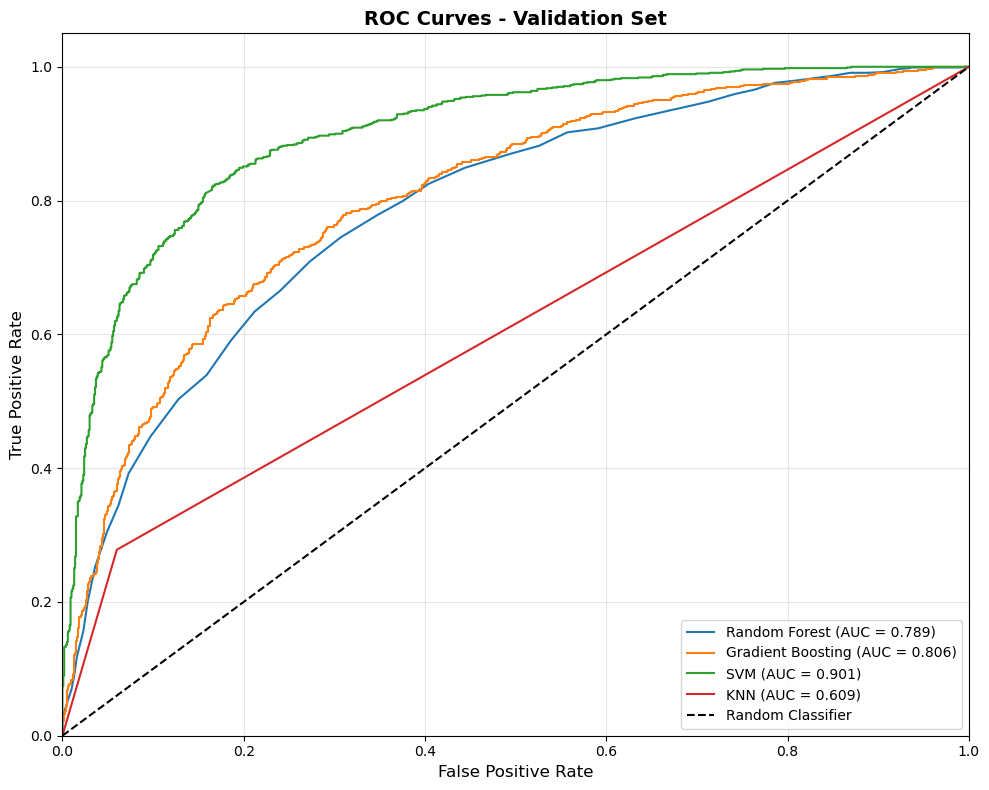

ROC curve saved to 'roc_curves_validation.png'


In [48]:
#Visualize ROC curves for all models from validation phase.
plt.figure(figsize=(10, 8))

for model_name, data in roc_data.items():
    plt.plot(data['fpr'], data['tpr'], 
             label=f"{model_name} (AUC = {data['auc']:.3f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Validation Set', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curves_validation.png', dpi=300, bbox_inches='tight')
plt.show()

In [50]:
#Test the final model on a new dataset.
print("\n--- Loading Cross-Dataset ---")
#Load new dataset features.
real_cross = np.load('test_cross_real_all_features.npz')
fake_cross = np.load('test_cross_fake_all_features.npz')

#Extract and combine features for each type.
X_cross_dict = {}
for feature in features_to_use:
    real_feat = real_cross[feature]
    fake_feat = fake_cross[feature]
    X_cross_dict[feature] = np.vstack([fake_feat,real_feat])
    print(f"  {feature}: {X_cross_dict[feature].shape[1]} features")
    
# Create labels (Real=1, Fake=0 to match training convention)
y_cross = np.hstack([np.zeros(len(fake_cross[features_to_use[0]])), np.ones(len(real_cross[features_to_use[0]]))])
print(f"\nCross-dataset size: {len(y_cross)} samples")
print(f"Real: {np.sum(y_cross == 1)}, Fake: {np.sum(y_cross == 0)}")

#Scale each feature individually using the saved scalers.
X_cross_scaled_dict = {}
for feature in features_to_use:
    X_cross_scaled_dict[feature] = scalers[feature].transform(X_cross_dict[feature])
X_cross_scaled = np.concatenate([X_cross_scaled_dict[f] for f in features_to_use], axis=1)
if use_pca:
    X_cross_final = pca.transform(X_cross_scaled)
    print(f"PCA applied: {X_cross_scaled.shape[1]} --> {X_cross_final.shape[1]} components")
else:
    X_cross_final = X_cross_scaled
# Get predictions with inference time
print("\nEvaluating on cross-dataset...")
cross_infer_start = time.time()
y_cross_pred = final_model.predict(X_cross_final)
cross_infer_time = time.time() - cross_infer_start
# Get probabilities
if hasattr(final_model, "predict_proba"):
    y_cross_proba = final_model.predict_proba(X_cross_final)[:, 1]
elif hasattr(final_model, "decision_function"):
    y_cross_proba = final_model.decision_function(X_cross_final)
else:
    y_cross_proba = None
print_metrics(y_cross, y_cross_pred, y_cross_proba, "Cross-Dataset", final_model_choice, cross_infer_time);


--- Loading Cross-Dataset ---
  lbp: 59 features
  hog: 1764 features
  color: 6 features
  gabor: 8 features

Cross-dataset size: 2000 samples
Real: 1000, Fake: 1000
PCA applied: 1837 --> 480 components

Evaluating on cross-dataset...

SVM - Cross-Dataset Results:
 Inference Time: 15.3335 seconds
 Accuracy: 0.4215
 Precision: 0.4574
 Recall: 0.8430
 F1 Score: 0.5930
 ROC-AUC: 0.0765
 Confusion Matrix:
   [[   0 1000]
 [ 157  843]]

 CONFUSION MATRIX BREAKDOWN:
  True Negatives  (TN):    0 - Correctly identified as Fake
  False Positives (FP): 1000 - Fake wrongly identified as Real
  False Negatives (FN):  157 - Real wrongly identified as Fake
  True Positives  (TP):  843 - Correctly identified as Real

 ERROR ANALYSIS:
  Total Errors: 1157/2000 (57.85%)
  False Positives: 1000 (50.00%) - Fake images classified as Real
  False Negatives: 157 (7.85%) - Real images classified as Fake
